In [1]:
import scanpy as sc
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import bbknn
import scipy.stats
import numpy as np

In [2]:
import sys
sys.path.insert(0, "../lib")

In [3]:
import sc_utils

In [4]:
mpl.rcParams["figure.figsize"] = (16, 12)

## Load annotated object from preprint

In [5]:
prev = sc.read_h5ad("../data/02preprint/10obj-named.h5ad")

In [6]:
prev

AnnData object with n_obs × n_vars = 39331 × 20128
    obs: 'orig.ident', 'n_genes', 'patient', 'day', 'type', 'replicate', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'leiden', 'cluster', 'purple', 'sars', 'Type 1 IFN Response', 'IFNA Response', 'IFNG Response', 'n_sars_genes', 'leiden_deep', 'COVID-19'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'n_cells-7', 'gene_ids-8', 'feature_types-8', 'n_cells-8', 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'high

## Load new object

Constructed with BBKNN: no SARS-CoV-2 genes in clustering, selected 4000 HVG with batch-effect correction, 100 total neighbors for graph construction

In [7]:
cur = sc.read_h5ad("../data/03dataset/01obj.h5ad")

In [8]:
cur

AnnData object with n_obs × n_vars = 150116 × 21825
    obs: 'orig.ident', 'n_genes', 'patient', 'day', 'type', 'replicate', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'leiden'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'n_cells-15', 'gene_ids-16', 'feature_types-16', 'n_cells-16', 'gene_ids-17', 'feature_types-17', 'n_cells-17', 'gene_ids-18', 'feature_types-18', 'n_cells-18', 'gene_ids-19', 'feature_types-19', 'n_cells-19', 'gene_ids-2', 'feature_types-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'n_cells-4', 'gene_ids-5

In [7]:
cur.obs["cluster"] = "NA"

Copy cluster annotations from previous object

In [8]:
cur.obs.cluster.loc[prev.obs.index] = prev.obs.cluster

/projects/b1038/Pulmonary/nmarkov/script/2020_Grant/single_cell_analysis/.venv/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
prev.obs["COVID-19"].value_counts()

True     28114
False    11217
Name: COVID-19, dtype: int64

Manually set COVID-19 status

In [12]:
cur.obs["COVID-19"] = True
cur.obs.loc[cur.obs["orig.ident"].isin([
    "Sample_8", "Sample_9", "Sample_10", "Sample_11"
]), "COVID-19"] = False

In [14]:
cur.obs["COVID-19"] = cur.obs["COVID-19"].astype("category")
cur.obs["patient"] = cur.obs["patient"].astype("category")

Add n_sars_genes field

In [15]:
sars_genes = cur.var_names[cur.var_names.str.startswith("SARS-CoV-2")]

In [16]:
sars_detected = (cur.raw.X[:, cur.var_names.isin(sars_genes)].todense() > 0).sum(axis=1).A[:, 0]

In [17]:
cur.obs["n_sars_genes"] = sars_detected

Add samples status field: fresh/cryo

In [18]:
cur.obs["sample_status"] = "Cryo"

In [19]:
cur.obs.loc[cur.obs["orig.ident"].isin(prev.obs["orig.ident"].unique()), "sample_status"] = "Fresh"

In [20]:
cur.obs.sample_status = cur.obs.sample_status.astype("category")

Plot previous clusters

/home/nmx5063/.local/share/virtualenvs/code-sz7XzLNG/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'cluster' as categorical


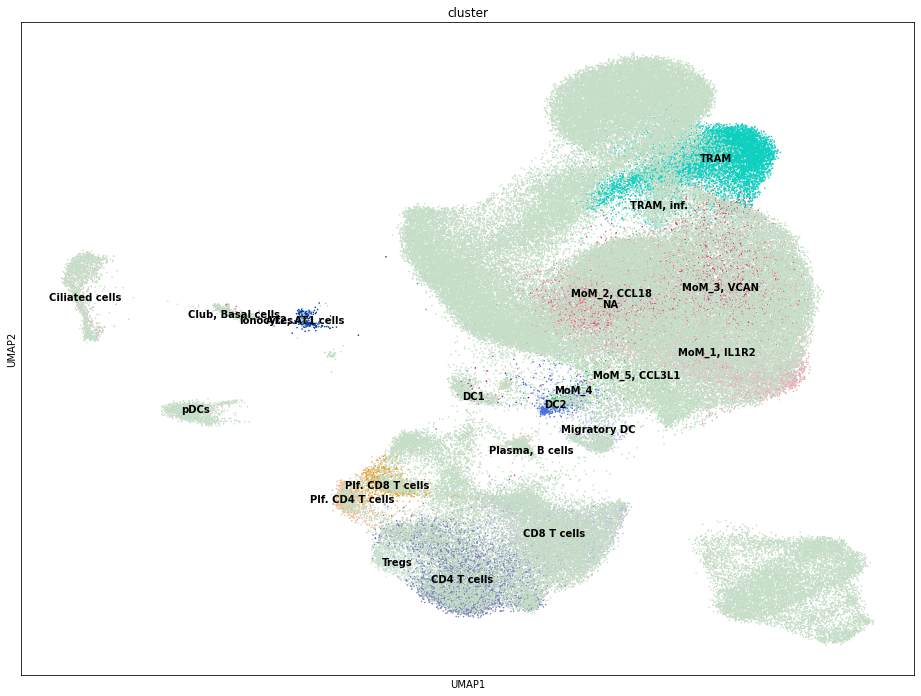

In [15]:
sc.pl.umap(cur, color="cluster", size=10, legend_loc="on data")

Plot COVID-19 status

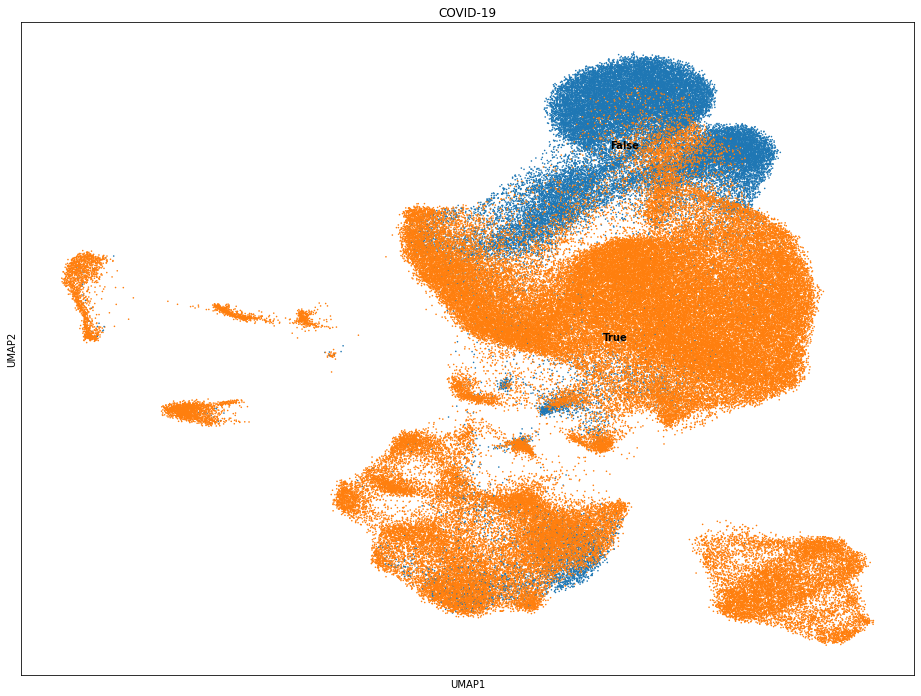

In [16]:
sc.pl.umap(cur, color="COVID-19", size=10, legend_loc="on data")

Split by patient

... storing 'cluster' as categorical


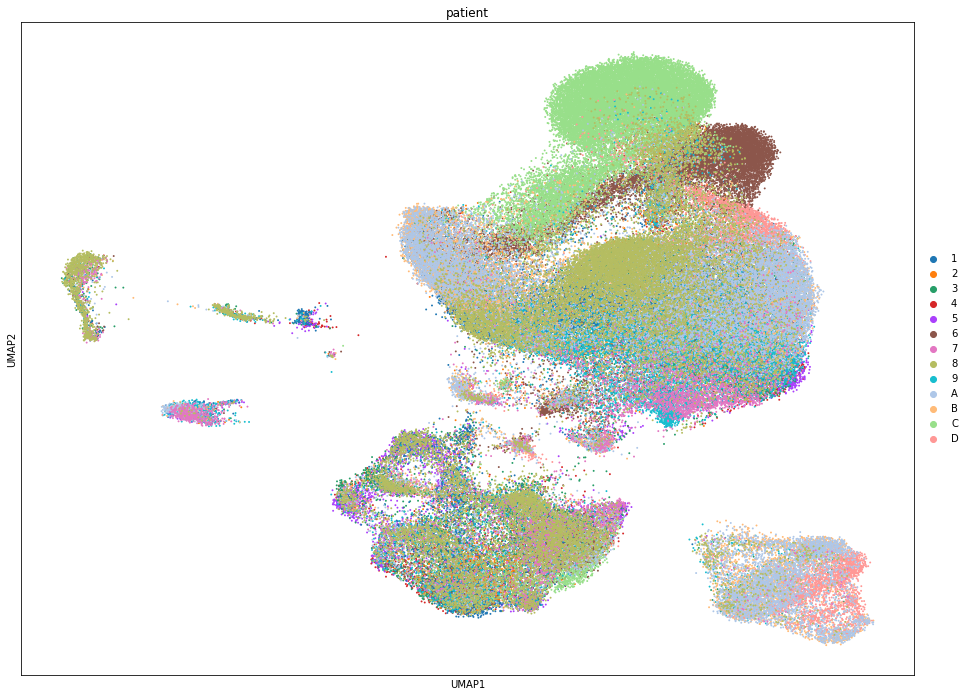

In [112]:
sc.pl.umap(cur, color="patient", size=15)

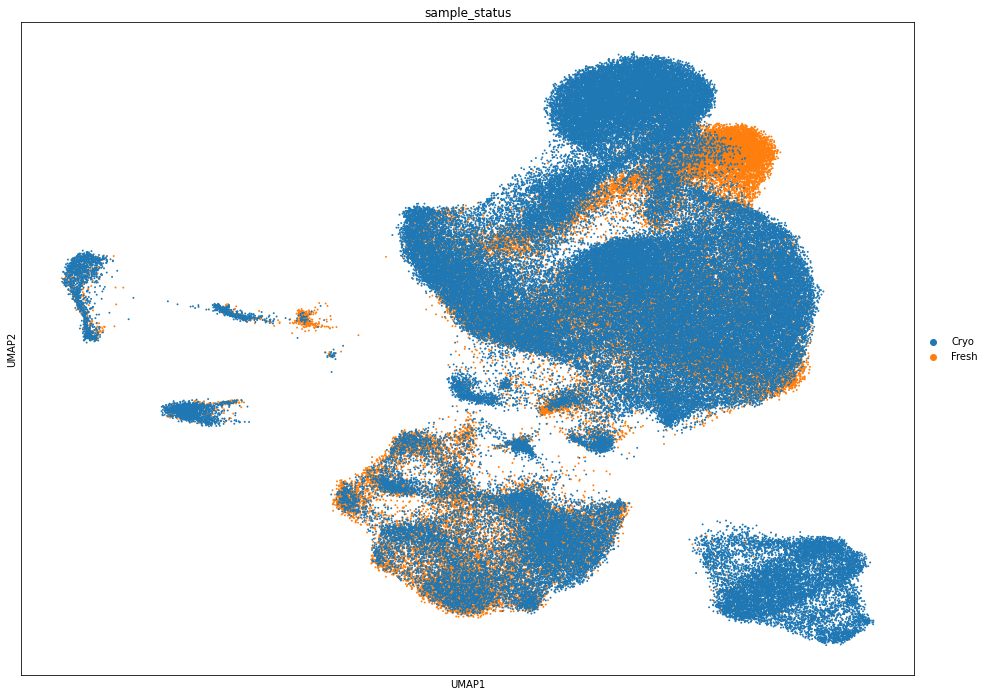

In [30]:
sc.pl.umap(cur, color="sample_status", size=15)

## Remove doublets

In [24]:
dbl_thresholds = {
    'Sample_1': 0.22,
    'Sample_2': 0.24,
    'Sample_3': 0.22,
    'Sample_4': 0.22,
    'Sample_5': 0.3,
    'Sample_6': 0.32,
    'Sample_7': 0.32,
    'Sample_8': 0.4,
    'Sample_9': 0.4,
    'Sample_10': 0.4,
    'Sample_11': 0.38,
    'Sample_12': 0.32,
    'Sample_13': 0.35,
    'Sample_14': 0.4,
    'Sample_15': 0.29,
    'Sample_16': 0.4,
    'Sample_17': 0.32,
    'Sample_18': 0.36,
    'Sample_19': 0.34,
    'Sample_20': 0.23,
}

In [28]:
doublets = []
for sample, threshold in dbl_thresholds.items():
    batch_num = cur.obs.batch.loc[cur.obs["orig.ident"] == sample].values[0]
    scores = pd.read_csv(f"../data/04dataset/doublets/{sample}_doublets.csv", index_col=0)
    sample_doublets = sample + "_" + scores["0"].loc[scores.doublet > threshold].str.replace("\d+$", "") + batch_num
    doublets.append(sample_doublets)
    print(f"{sample} has {sample_doublets.size}")
doublets = pd.concat(doublets)
doublets.shape

Sample_1 has 229
Sample_2 has 208
Sample_3 has 227
Sample_4 has 219
Sample_5 has 107
Sample_6 has 95
Sample_7 has 27
Sample_8 has 28
Sample_9 has 32
Sample_10 has 88
Sample_11 has 186
Sample_12 has 36
Sample_13 has 90
Sample_14 has 46
Sample_15 has 142
Sample_16 has 170
Sample_17 has 91
Sample_18 has 192
Sample_19 has 210
Sample_20 has 166


(2589,)

In [29]:
cur.obs["doublet"] = False
cur.obs.doublet[cur.obs_names.isin(doublets)] = True
cur.obs["doublet"] = cur.obs["doublet"].astype("category")
cur.obs.doublet.value_counts()

/projects/b1038/Pulmonary/nmarkov/script/2020_Grant/single_cell_analysis/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


False    147535
True       2581
Name: doublet, dtype: int64

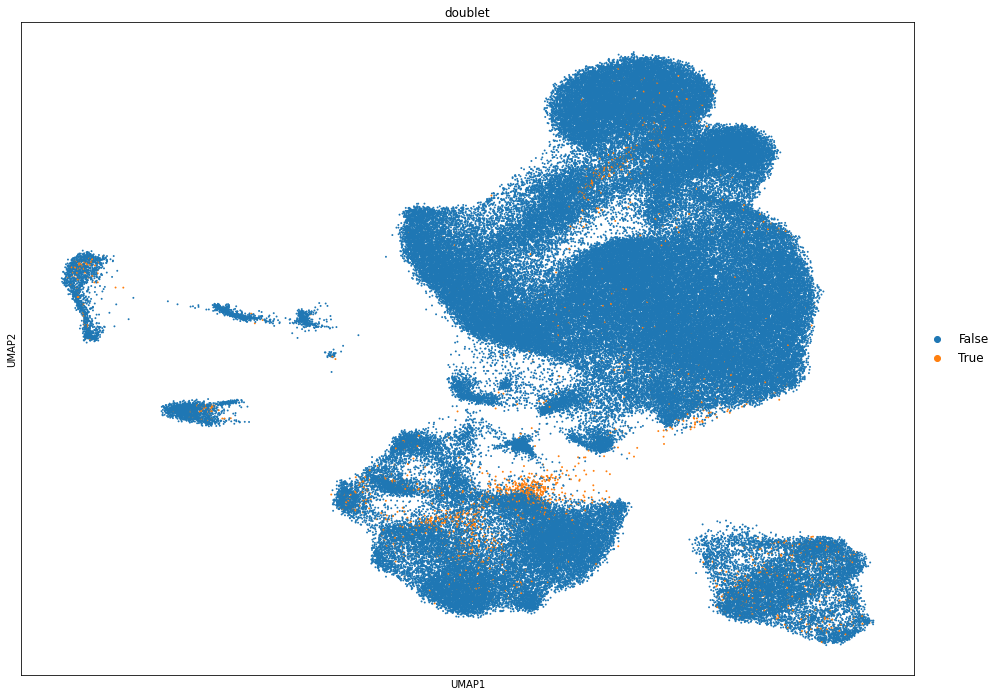

In [120]:
ax = sc.pl.umap(
    cur, 
    color="doublet", 
    size=15, 
    show=False, 
    legend_fontsize=12, 
    legend_fontweight="normal",
    legend_fontoutline=5,
    cmap="YlOrRd"
)

In [30]:
doublets

6         Sample_1_AAACGGGAGGAGTACC-0
67        Sample_1_AACCGCGTCATCTGCC-0
94        Sample_1_AACTCTTGTACCATCA-0
104       Sample_1_AACTTTCTCATGTGGT-0
158       Sample_1_AATCCAGTCGAGCCCA-0
                    ...              
4760    Sample_20_TTCGGTCGTTATGCGT-15
4782    Sample_20_TTCTCAAGTGTGGTTT-15
4833    Sample_20_TTGACTTGTGTTTGTG-15
4846    Sample_20_TTGCCGTTCAAAGTAG-15
4918    Sample_20_TTTCCTCTCACCATAG-15
Name: 0, Length: 2589, dtype: object

In [31]:
doublets.to_csv("01cells-to-exclude.csv", index=False, header=False)

In [32]:
cur2 = cur[cur.obs.doublet == False, :]

## Recluster real deep to remove low-quality cells

In [33]:
sc.tl.leiden(cur2, resolution=10, key_added="leiden_deep")

Trying to set attribute `.obs` of view, copying.


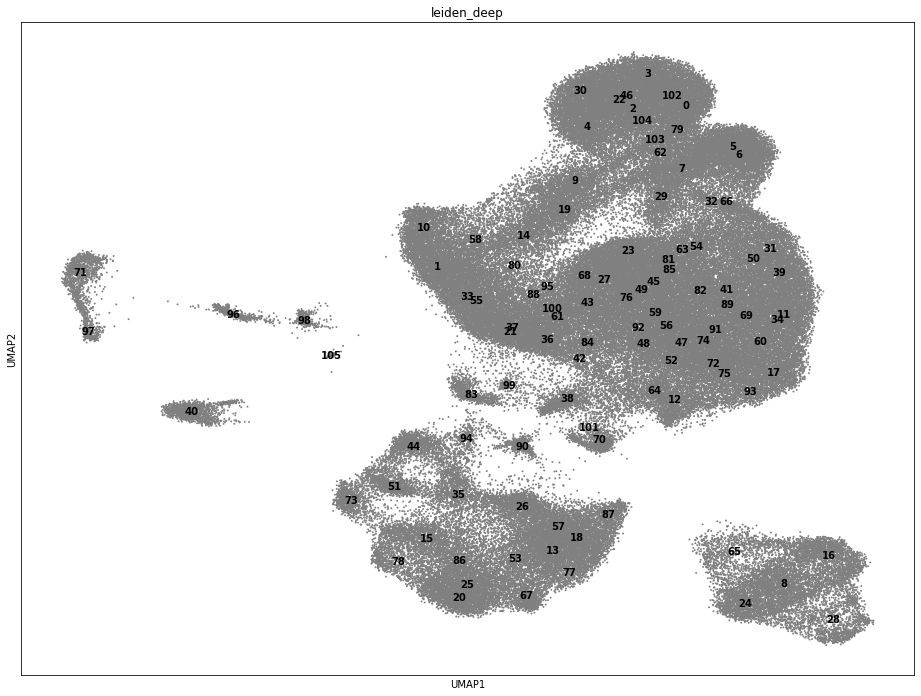

In [124]:
ax = sc.pl.umap(cur2, 
           color="leiden_deep", 
           size=15, 
           legend_loc="on data",
           show=False)

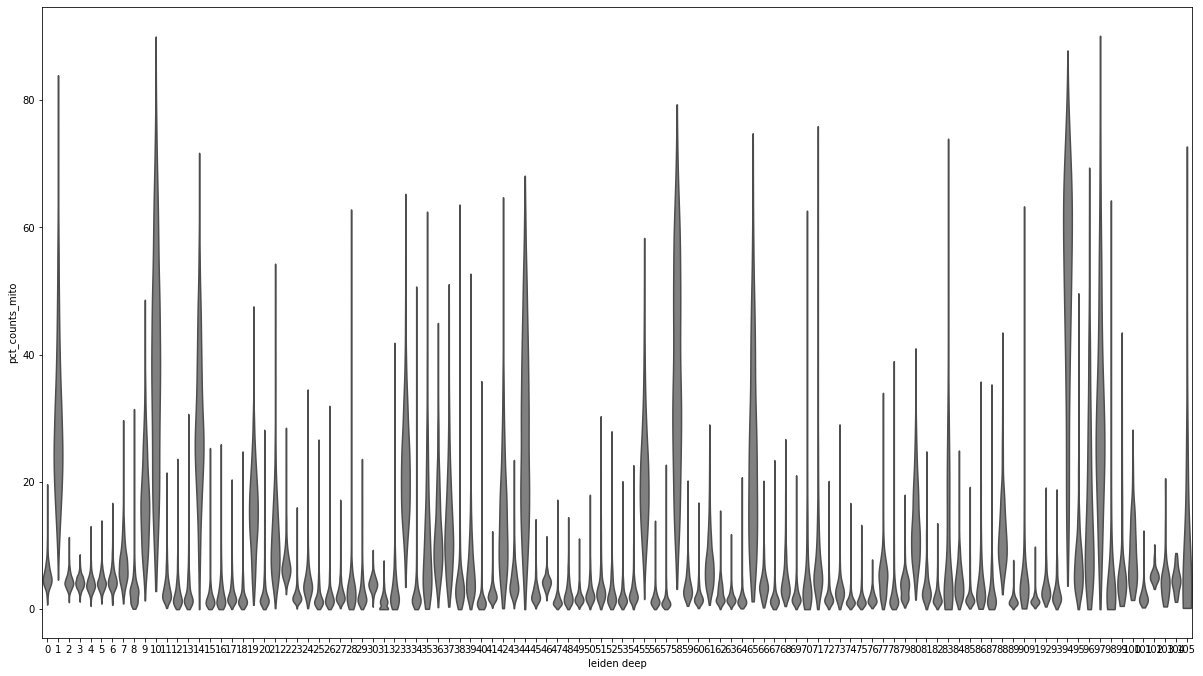

In [166]:
ax = sc.pl.violin(cur2, ["pct_counts_mito"], groupby="leiden_deep", size=0, show=False)
ax.figure.savefig("01vln-mito.pdf")

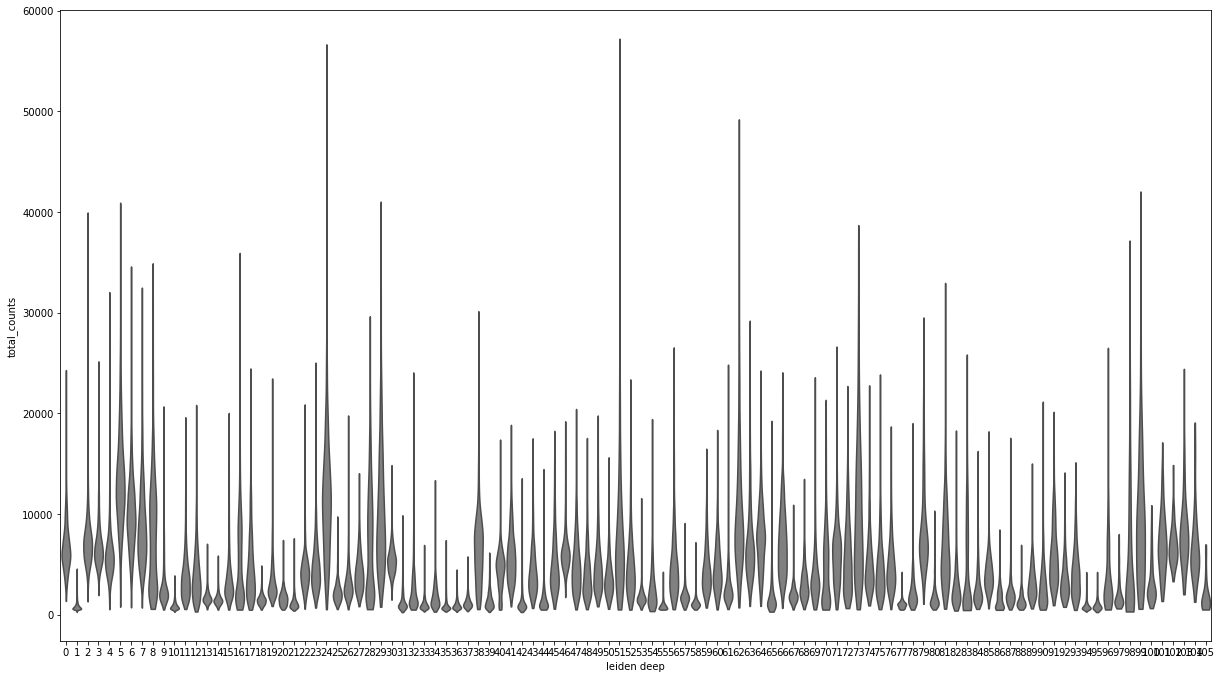

In [167]:
ax = sc.pl.violin(cur2, ["total_counts"], groupby="leiden_deep", size=0, show=False)
ax.figure.savefig("01vln-numis.pdf")

/home/nmx5063/.local/share/virtualenvs/code-sz7XzLNG/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


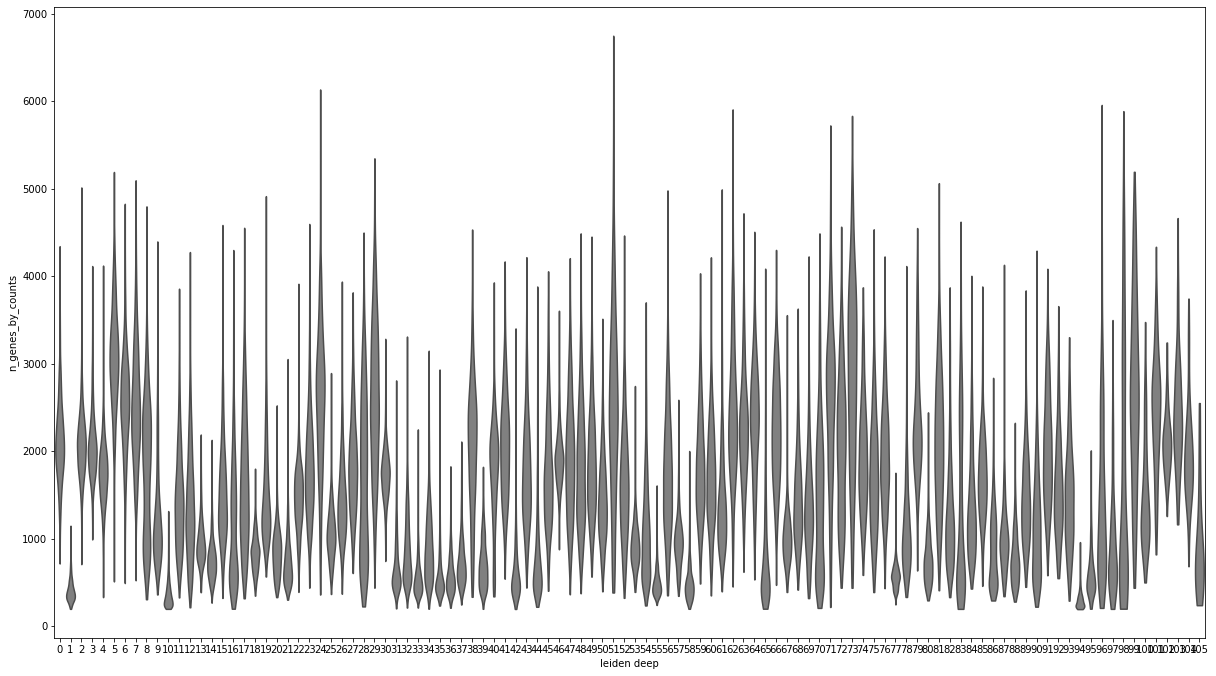

In [169]:
ax = sc.pl.violin(cur2, ["n_genes_by_counts"], groupby="leiden_deep", size=0, show=False)
ax.figure.savefig("01vln-ngenes.pdf")

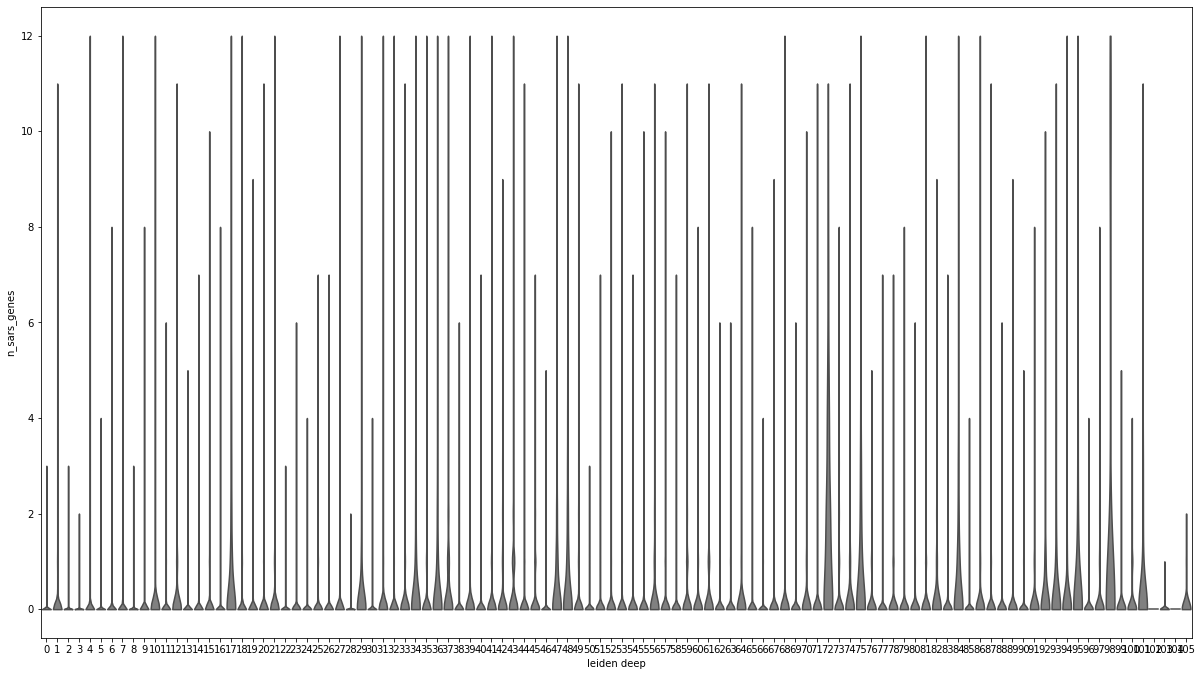

In [54]:
sc.pl.violin(cur2, "n_sars_genes", groupby="leiden_deep", size=0)

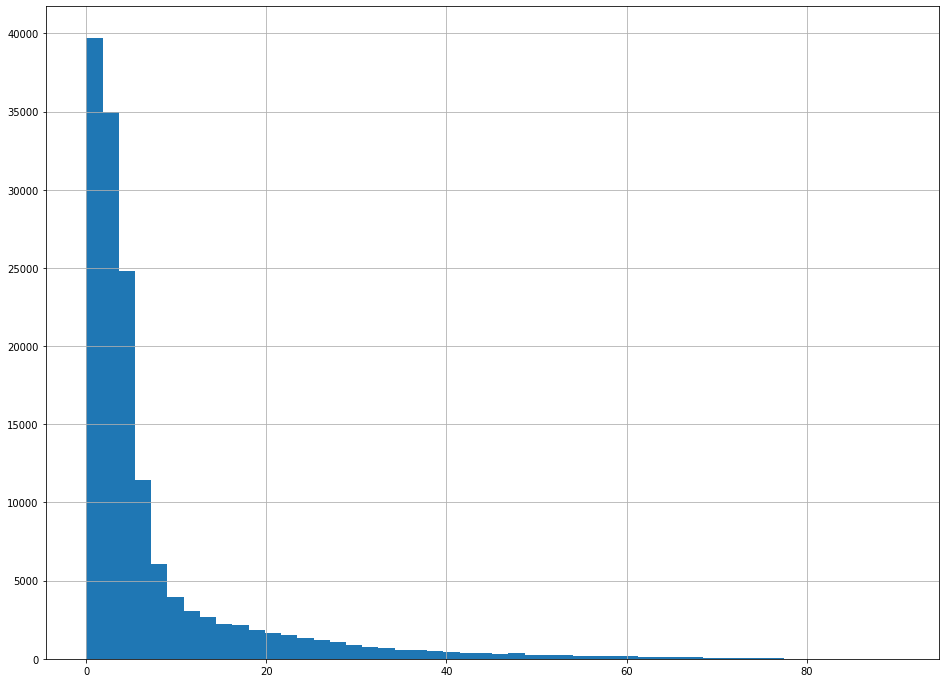

In [57]:
cur2.obs.pct_counts_mito.hist(bins=50)

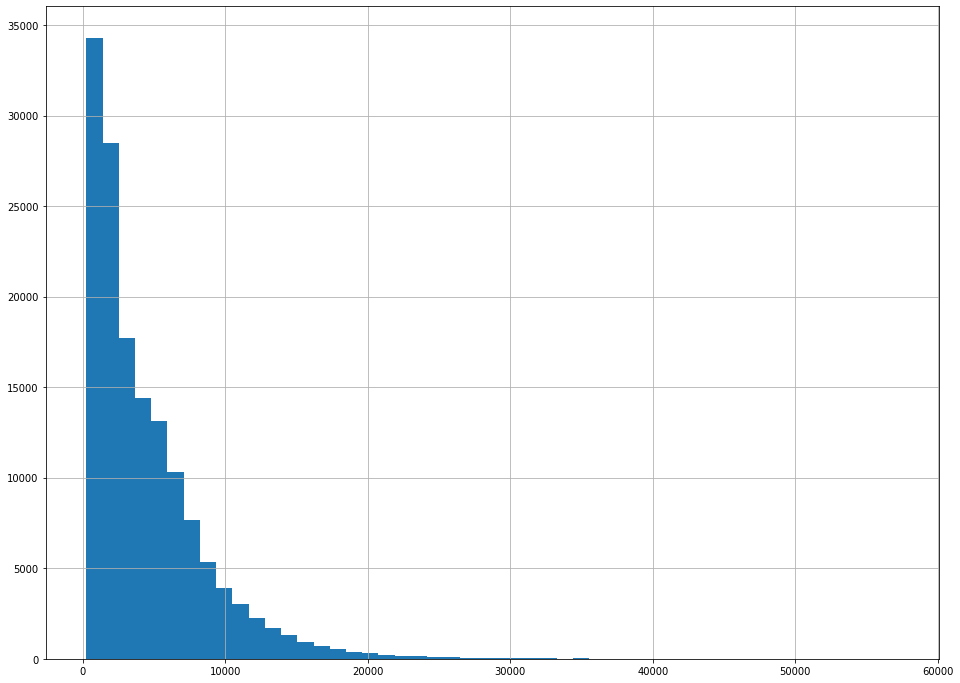

In [58]:
cur2.obs.total_counts.hist(bins=50)

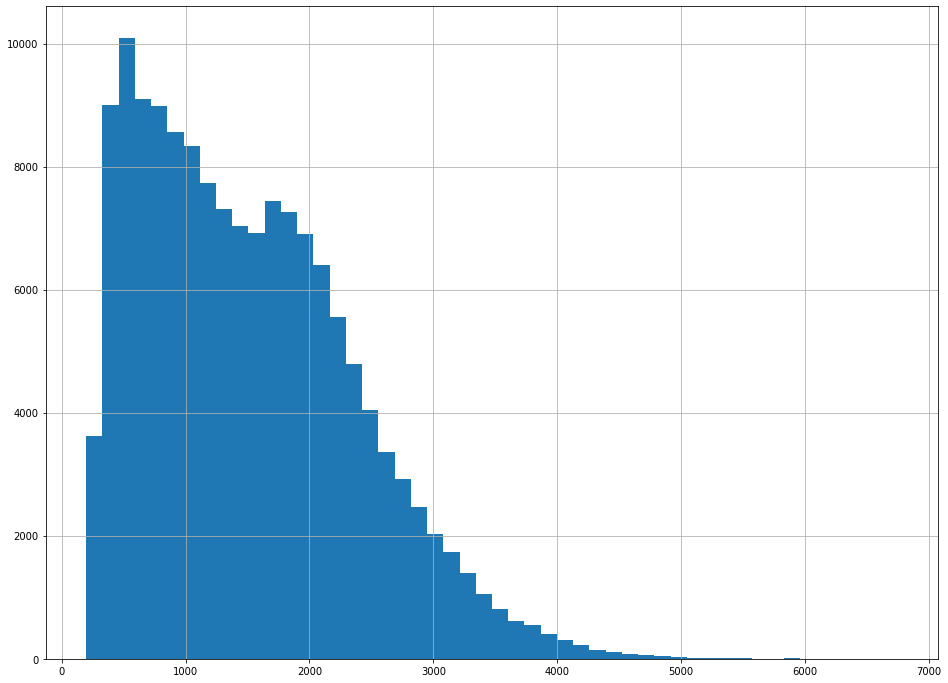

In [60]:
cur2.obs.n_genes_by_counts.hist(bins=50)

In [34]:
pct_mito_norm = cur2.obs.pct_counts_mito
pct_mito_norm = pct_mito_norm - pct_mito_norm.min()
pct_mito_norm = pct_mito_norm / pct_mito_norm.max()

n_umis_norm = cur2.obs.total_counts
n_umis_norm = n_umis_norm - n_umis_norm.min()
n_umis_norm = n_umis_norm / n_umis_norm.max()

n_genes_norm = cur2.obs.n_genes_by_counts
n_genes_norm = n_genes_norm - n_genes_norm.min()
n_genes_norm = n_genes_norm / n_genes_norm.max()

In [35]:
data = []
for c in cur2.obs.leiden_deep.cat.categories:
    cell_idx = cur2.obs.leiden_deep == c
    pct_mito = cur2.obs.pct_counts_mito.loc[cell_idx]
    n_umis = cur2.obs.total_counts.loc[cell_idx]
    n_genes = cur2.obs.n_genes_by_counts.loc[cell_idx]
    n_sars = cur2.obs.n_sars_genes.loc[cell_idx]
    mito_umi_corr = scipy.stats.linregress(pct_mito, n_umis).rvalue
    mito_genes_corr = scipy.stats.linregress(pct_mito, n_genes).rvalue
    mean_mito = pct_mito.mean()
    mean_n_umis = n_umis.mean()
    mean_n_genes = n_genes.mean()
    mean_n_sars = n_sars.mean()
    big_cluster = cur2.obs.leiden[cell_idx].value_counts().index[0]
    data.append([
        c, 
        pct_mito.size,
        big_cluster,
        mito_umi_corr, 
        mito_genes_corr, 
        mean_mito, 
        mean_n_umis, 
        mean_n_genes, 
        mean_n_sars
    ])

In [36]:
data = pd.DataFrame(data, columns=["c", "size", "big_cluster", "mito_umi_corr", "mito_genes_corr", "mean_mito", "mean_n_umis", "mean_n_genes", "mean_n_sars"])

In [37]:
data = data.set_index("c")

In [174]:
data.to_csv("01tech-vars.csv")

In [38]:
data

,size,big_cluster,mito_umi_corr,mito_genes_corr,mean_mito,mean_n_umis,mean_n_genes,mean_n_sars
c,,,,,,,,
0,2952,0,-0.316614,-0.401831,5.400126,6805.070312,2120.846206,0.006436
1,2821,3,0.031299,-0.473037,29.373325,821.327209,411.916342,0.095711
2,2795,0,-0.313200,-0.382059,4.424454,7398.356445,2095.908408,0.004293
3,2659,0,-0.127229,-0.178062,4.286672,6842.448242,2062.521249,0.001880
4,2553,0,-0.292494,-0.336402,4.105397,5825.682129,1749.436349,0.027027
...,...,...,...,...,...,...,...,...
101,233,2,-0.244301,-0.311163,2.124533,7095.484863,2462.278970,0.515021
102,225,0,-0.288407,-0.350966,5.381705,7055.142090,2105.311111,0.000000
103,118,0,-0.389273,-0.461458,4.665753,8153.423828,2429.906780,0.008475


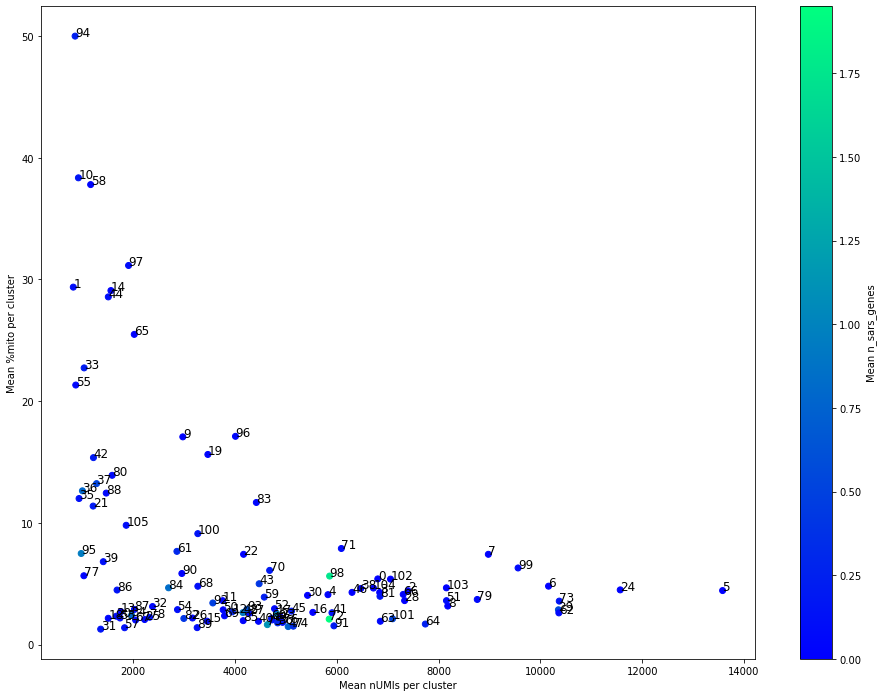

In [161]:
plt.scatter(data.q10_n_umis, data.q10_mito, c=data.mean_n_sars, cmap="winter")
plt.colorbar(label="Mean n_sars_genes")
for i, txt in enumerate(data.index):
    plt.annotate(txt, (data.q10_n_umis[i], data.q10_mito[i]), fontsize=12)
plt.xlabel("Mean nUMIs per cluster")
plt.ylabel("Mean %mito per cluster")
plt.savefig("01tech-vars.pdf")

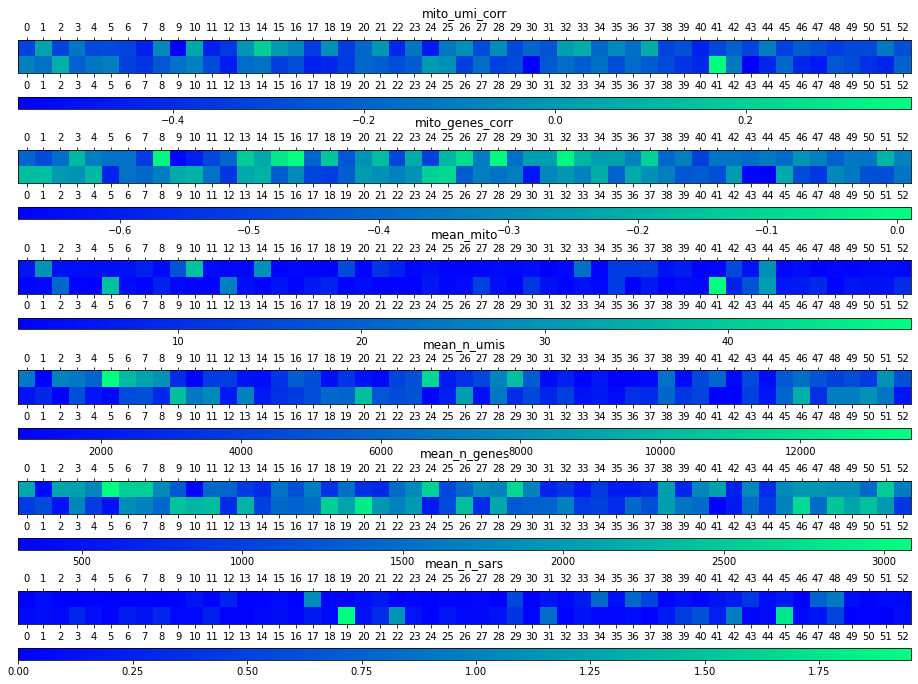

In [39]:
fig, axes = plt.subplots(12, 1)
for i, c in enumerate(data.columns[2:]):
    data_r = []
    data_r.append(data[c][:53])
    data_r.append(data[c][53:])
    ax = axes[i * 2]
    z = ax.imshow(data_r, cmap="winter")
    ax.set_title(c)
    ax.set_xticks(list(range(53)))
    ax.tick_params(top=True, labeltop=True, left=False, labelleft=False)
    cax = axes[i * 2 + 1]
    fig.colorbar(z, cax=cax, orientation="horizontal")
    p = cax.get_position()
    p.y0 += 0.03
    p.y1 -= 0.01
    cax.set_position(p)

Manually picked clusters to exclude:

In [40]:
to_exclude = ["94", "10", "58", "1", "14", "44", "65", "33", "55", "42", 
              "80", "88", "35", "36", "37", "95", "21", "39", "77", "84", "68",
              "43", "100", "9", "19"]

In [41]:
already_excluded = pd.read_csv("01cells-to-exclude.csv", index_col=0)

cells_to_exclude = cur2.obs.leiden_deep.isin(to_exclude)

pd.concat([pd.Series(already_excluded.index), pd.Series(cells_to_exclude.index[cells_to_exclude])], axis=0).to_csv(
    "01cells-to-exclude.csv",
    index=False,
    header=False
)